# Word Boundary

In [87]:
import math
import numpy as np
from graphviz import Digraph

In [88]:
START = 'START'
END = 'END'
CN = 'CN'
FN = 'FN'
V_1 = 'V-1'
V_RA = 'V-ra'
V_WA = 'V-wa'
ADN = 'AdN'
AUX_V = 'Aux-V'
CASE_P = 'Case-P'
CONJ_P = 'Conj-P'
EN = 'EN'
SUF = 'Suf'

vocabs = {
    'こ': [SUF],
    'こと': [FN],
    'この': [ADN],
    'た': [AUX_V],
    'で': [CASE_P, V_1],
    'と': [CASE_P, CONJ_P],
    'な': [V_RA],
    'に': [CASE_P],
    'にな': [V_WA],
    'ひ': [CN],
    'ひと': [CN],
    'ひとこと': [CN],
    'っ': [EN],
    '元気': [CN]
}

indices = {
    START: 0,
    END: 0,
    CN: 1,
    FN: 2,
    V_1: 3,
    V_RA: 4,
    V_WA: 5,
    ADN: 6,
    AUX_V: 7,
    CASE_P: 8,
    CONJ_P: 9,
    EN: 10,
    SUF: 11
}

conn_rules = np.array([
    [0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0], # START
    [1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1], # CN
    [1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1], # FN
    [0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 0], # V-1
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], # V-ra
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0], # V-wa
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], # AdN
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0], # Aux-V
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], # Case-P
    [1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0], # Conj-P    
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0], # EN
    [1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1]  # Suf
])

In [89]:
def getLengthInfo():
    min = math.inf
    max = -math.inf
    for word in vocabs.keys():
        min = min if len(word) > min else len(word)
        max = max if len(word) < max else len(word)
    return (min, max)

min, max = getLengthInfo()

class Node:
    def __init__(self, val=None, pos=None):
        self.parent = None
        self.childs = []
        self.val = val
        self.pos = pos
        
    def addChild(self, child=None):
        self.childs.append(child)
        child.setParent(self)
        return child
    
    def isEndNode(self):
        return self.val is None and self.pos == END
    
    def isStartNode(self):
        return (self.parent == None and self.val is None and self.pos == START)
    
    def setParent(self, parent=None):
        self.parent = parent
    
    def getChilds(self):
        return self.childs
    
    def getParent(self):
        return self.parent
    
    def getVal(self):
        if self.val is None:
            return ''
        return self.val
    
    def getPos(self):
        return self.pos
    
    def getId(self):    
        id = str(self.val) + '-' + str(self.pos)
        node = self.parent
        while node is not None:
            id += str(node.getVal())[::-1]
            node = node.getParent()
        return id
    
    def __repr__(self):
        if self.val is None:
            return self.pos
        return '%s\n%s' % (self.val, self.pos)

def buildTree(node, text):
    prevPos = node.getPos()
    if text == '' and conn_rules[indices.get(prevPos), indices.get(END)]:
        childNode = node.addChild(Node(None, END))
        writeToDotFile(node, childNode)
        return
    
    for i in range(min, max + 1):
        if i <= len(text):
            word = text[:i]
            remainingText = text[i:]
            poses = vocabs.get(word, [])
            for pos in poses:
                if conn_rules[indices.get(prevPos), indices.get(pos)]:
                    childNode = node.addChild(Node(word, pos))
                    writeToDotFile(node, childNode)
                    buildTree(childNode, remainingText)

root = Node(None, START)
dot = Digraph(comment='Word Boundary')
dot.node(str(root.getId()), str(root))
nodeSet = set()
edgeSet = set()

def writeToDotFile(node, childNode):
    global dot, nodeSet, edgeSet
    childNodeId = str(childNode.getId())
    nodeId = str(node.getId())
    if childNodeId not in nodeSet:
        dot.node(childNodeId, str(childNode))
        nodeSet.add(childNodeId)
        
    if (nodeId, childNodeId) not in edgeSet:
        dot.edge(nodeId, childNodeId)
        edgeSet.add((nodeId, childNodeId))

text = 'このひとことで元気になった'
buildTree(root, text)

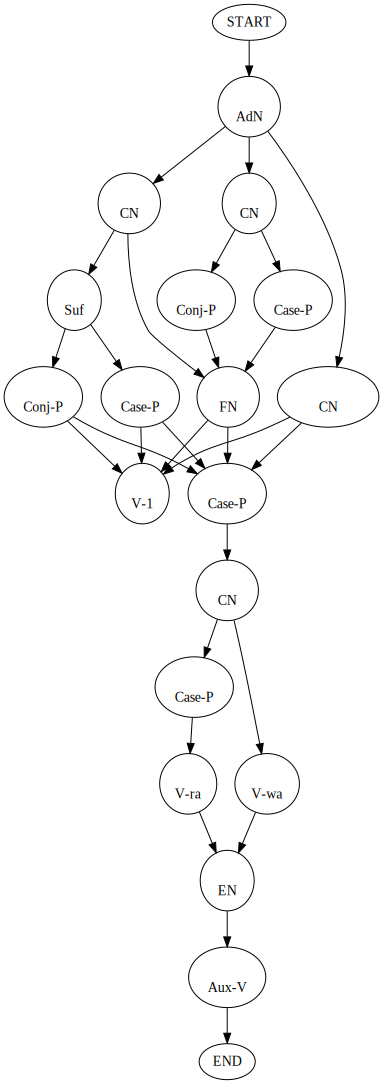

In [90]:
dot